In [119]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import pydub as pd
import sounddevice as sd
import os
import random
import math
import tensorflow as tf
from scipy.io.wavfile import write
from keras.optimizers import Adam, RMSprop
from keras import layers
from tensorflow import keras
from keras.layers import AveragePooling1D ,LSTM, Dense, TimeDistributed, RepeatVector, Flatten, Reshape, BatchNormalization, Bidirectional, AveragePooling1D, Activation, Attention, SimpleRNN, Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose, UpSampling1D, MaxPooling1D
from keras.activations import relu, tanh, linear, softmax, elu
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pennylane as qml



In [ ]:
path = r'/home/dgx/Desktop/racoon/music_generate/music001'
music = []
music_list = os.listdir(path=path)
for num in range(len(os.listdir(path=path))):
    print('Loading Music:', music_list[num])
    music.append(lb.load(os.path.join(path, music_list[num])))
    print('Finished')

In [ ]:
class music_process:
    def __init__():
        super.__init__()
    def ran_music_seq(data, sec, ff=22050):
        sequence = sec*ff
        start = random.randint(0, (len(data[0])-sequence))
        result = []
        for lent in range(sequence):
          result.append(data[0][start])
          start+=1
        return result
    def half_samplerate(data):
        result = []
        for num in range(len(data)):
            if num%2==0:
                result.append(data[num])
        return result
    def double_samplerate(data):
        result = []
        for num in range(len(data)):
            result.append(data[num])
            result.append(data[num])
        return result
    def normalize_freq(data, sample_rate):
        normal_result = []
        for dot in data:
            normal_result.append(dot/sample_rate)
        return normal_result


In [ ]:
# 20sec 22050
train_data = []
for i in range(len(music)):
    for num in range(50):
        train_data.append(music_process.ran_music_seq(music[i], 20))

In [ ]:
# scaler = MinMaxScaler().fit(train_data)
# train_data = scaler.transform(train_data)


In [70]:
sample_rate = 22050
sample_sec = 20
metr = 'mae', 'msle'
data_train = np.array(train_data)
train, test = train_test_split(data_train, train_size = 0.8)
train = np.reshape(train, (train.shape[0] ,sample_sec, sample_rate)) 

In [ ]:
with tf.distribute.MirroredStrategy().scope():   
    model = Sequential()
    model.add(Input((sample_sec, sample_rate)))
    model.add(Bidirectional(LSTM(2048 ,return_sequences= True,)))
    model.add(Activation(tanh))
    model.add(Bidirectional(LSTM(1024, return_sequences=True)))
    model.add(Activation(tanh))
    model.add(Conv1D(512, 5,activation='tanh'))
    model.add(Activation(tanh)) 
    model.add(BatchNormalization())
    model.add(Dense(256, activation='tanh'))  
    model.add(BatchNormalization())
    model.add(Dense(128,  activation='tanh'))
    model.add(Dense(64, activation='relu'))
    model.add(MaxPooling1D((2)))
    model.add(Activation(tanh))
    model.add(BatchNormalization())
    model.add(Dense(128,  activation='tanh'))
    model.add(Conv1DTranspose(256, 3, activation='tanh'))
    model.add(Bidirectional(LSTM(512,  return_sequences=True)))
    model.add(Activation(tanh))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(1024, return_sequences=True, activation='tanh')))
    model.add(Bidirectional(LSTM(2048, return_sequences=True)))
    model.add(Activation(tanh))
    model.add(UpSampling1D(2))
    model.add(TimeDistributed(Dense(sample_rate, activation='tanh')))
    keras.utils.plot_model(model, show_shapes = True, to_file='mode2.png')
    model.compile(optimizer = Adam(0.001),
                  loss = 'mse',
                  metrics=  [metr])
    history = model.fit(train,train, batch_size = 200, epochs = 2000)

In [74]:
def plot_model(metr, show = True, save_path = None):
    for seq in metr:
        plt.plot( history.history[seq])
    plt.title('Model Metrices')
    plt.legend(metr)
    plt.ylabel('Metrices')
    plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    if show == True:
        plt.show()
    if save_path!=None:
        plt.savefig(save_path+'mertices.png')
        plt.clf()
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if show == True:
        plt.show()
    if save_path!=None:
        plt.savefig(save_path+'loss.png')

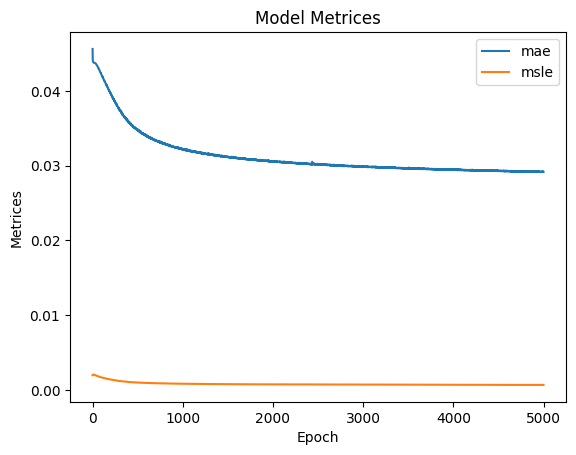

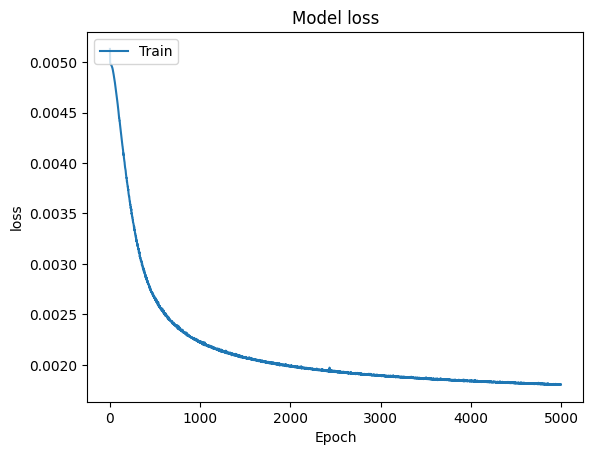

In [147]:
plot_model(metr, True)

In [150]:
pre = model.predict(train)
pre_res = np.reshape(pre, (pre.shape[0], sample_rate*20))
ori = np.reshape(train, (pre.shape[0], sample_rate*20))
# pre_res = scaler.inverse_transform(pre_res)

25/25 [==============================] - 8s 27ms/step


In [ ]:
sd.play(pre_res[0])

ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred


ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun o

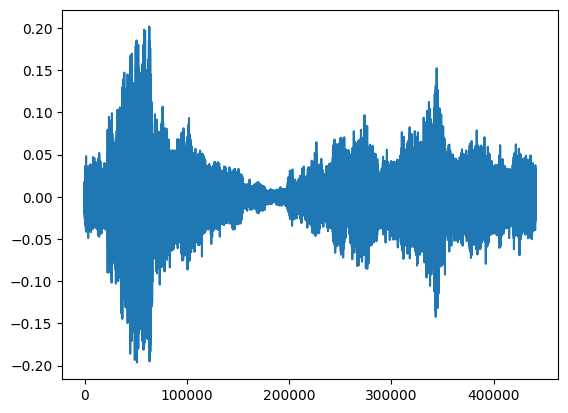

In [149]:
plt.plot(pre_res[2])

In [82]:
for num in range(10):
    write(f'music_gener/music{num}.wav', sample_rate, pre_res[num*50])
    # write(f'music_gener/music17_ori_{num}.wav', sample_rate, ori[num*50])

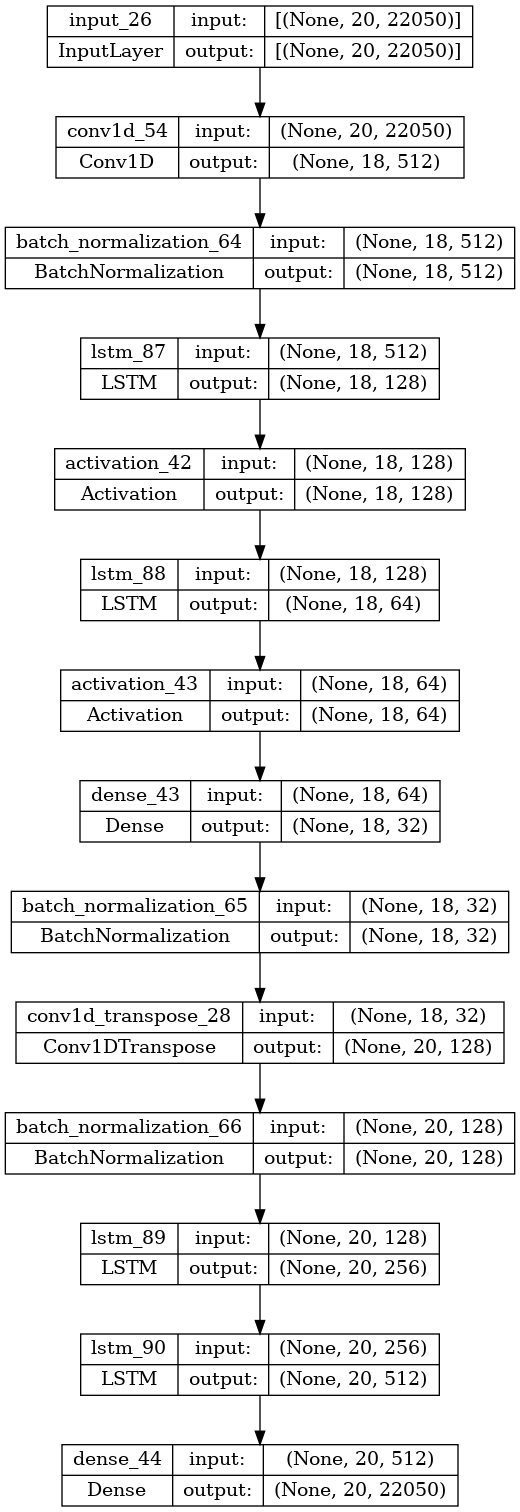

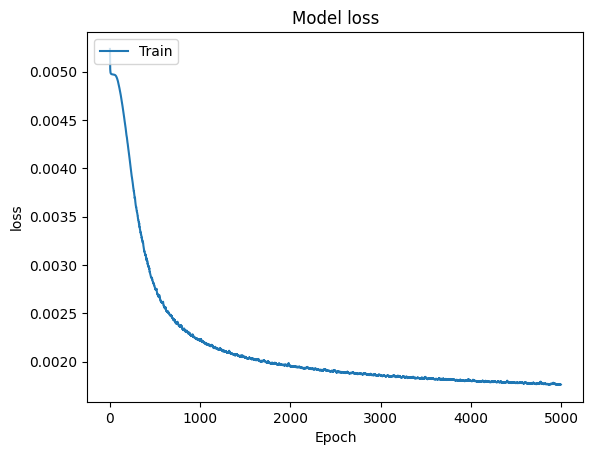

In [145]:
# save all info
model_list = np.sort(os.listdir('models'))
model_check = os.listdir('models/'+model_list[-1])
if len(model_check) != 0:
    path = f'models/{int(model_list[-1])+1}/'
    os.mkdir(path)
else:
    path = f'models/{int(model_list[-1])}/'
os.mkdir(path+'music')
for num in range(10):
    write(path+f'music/music{num}.wav', sample_rate, pre_res[num*50])
np.save(path+'music_data.npy', pre_res)
plot_model(metr=metr, show = False,save_path= path)
model.save (path+'model.h5', save_format='tf')
keras.utils.plot_model(model, show_shapes = True, to_file=path+'model.png')

In [96]:
model_list